In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import numpy     as np
import xarray    as xr
import time      as clock
import shapefile as shp
import warnings
xr.set_options(keep_attrs=True)
client_runs   = False

/home/a/a270275/tripyview/tripyview/sub_data.py:8: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


/home/a/a270275/tripyview


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [3]:
# parameters
#___Dask Client Parameters____________________________________________________________
do_papermill      = False
do_parallel       = True
parallel_tnprc    = 128                          # total number of available CPUs
parallel_nprc     = 72                           # number of dask workers
parallel_nprc_bin = parallel_tnprc-parallel_nprc # number of processor used to parallize the binning loop
parallel_tmem     = 200                          # max. available RAM

#___Mesh Path & Save Path_____________________________________________________________
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path         = '/work/ab0246/a270092/input/fesom2/core2/'
save_path         = '/work/ab0995/a270275/runconfig/test' #'~/figures/test_papermill/'
save_fname        = None # filename from papermill come in through save_fname
tripyrun_name     = None # papermill workflow name of notebook 
tripyrun_analysis = None # papermill diagnostic driver
tripyrun_spath_nb = None # papermill path to processed notebooks
tripyrun_spath_fig= None # papermill path to processed figures

#___Data Path & Input Names___________________________________________________________
input_paths   = list()
input_paths.append('/work/ab0995/a270275/experiments/5Ymulti_diag/outdata/fesom/')


input_names   = list()
input_names.append('Fesom 2.6')


# n_cycl: which spinupcycle should be plottet if do_allcycl all spinupcycles from [1...n_cycle] are plottet, if None path is directly used
n_cycl    = None
do_allcycl= False
vname     = 'temp'
year      = [1960,1961]
mon, day, record, box, depth = None, None, None, None, None

#___Define Reference Data, Year, Mon ...______________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None # '/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/'
ref_name  = None # 'TKE'
ref_year  = None #[1979, 2019]
ref_mon   = None
ref_day   = None
ref_record= None

#___Define Transects via [ [lon], [lat], transect-name ]______________________________
input_transect = list()
input_transect.append([[-66, -66],[-67, -55], 'Drake Passage'])
input_transect.append([[ -30,  -30],[-80, 90], '30°W, 80°S-90°N'])
# input_transect.append([[-57.0,-52.1,-49.8,-49.5,-49.0,-47.6,-45.7,-44.0,-42.8,-37.8,-35.2,-30.6,-27.9,-21.0,-12.3,-9.2,-4.0],
#                        [ 51.0, 52.7, 53.6, 55.0, 56.5, 59.0, 59.8, 60.4, 60.0, 59.6, 59.2, 58.9, 58.0, 58.0, 57.5,57.0,57.0], 
#                        'OSNAP'])
# input_transect.append([[-56.5,-52.1,-49.8,-49.5,-49.0,-47.6,-45.7,-44.0],
#                        [ 51.0, 52.7, 53.6, 55.0, 56.5, 59.0, 59.8, 60.4], 
#                        'OSNAP-West'])
# input_transect.append([[-44.0,-42.8,-37.8,-35.2,-30.6,-27.9,-21.0,-12.3,-9.2,-4.0],
#                        [ 60.4, 60.0, 59.6, 59.2, 58.9, 58.0, 58.0, 57.5,57.0,57.0], 
#                        'OSNAP-East'])

#___Define Climatology________________________________________________________________
which_clim= 'phc3'
clim_path = '/work/ab0246/a270092/input/fesom2/hydrography/phc3.0/phc3.0_annual.nc'
#'/work/ab0246/a270092/input/fesom2/hydrography/phc3.0/phc3.0_annual.nc'

#___Define Colormap Parameters________________________________________________________
# papermill doesnt like multi variable alignment in a single line
cstr      = 'blue2red'
cnum      = 15
cref      = 0
crange    = None
cmin      = None
cmax      = None
cfac      = None
climit    = None
chist     = True
ctresh    = 0.995

ref_cstr  = 'wbgyr'
ref_cnum  = 15
ref_cref  = None
ref_crange= None
ref_cmin  = None
ref_cmax  = None
ref_cfac  = None
ref_climit= None
ref_chist = True
ref_ctresh= 0.995

#___Define Plot Parameters____________________________________________________________
ncol              = 2      # number of pannel columns in figure
nrow              = None
box               = [-180, 180, -90, 90]
do_plt            = 'tcf'  # plot pcolor (tpc) or contourf (tcf)
plt_contb         = True   # background contour line (thin)
plt_contf         = False  # contour line of main colorbar steps 
plt_contr         = False  # contour line of reference value 
plt_contl         = False  # label contourline of main colorbar steps 
do_rescale        = None   # rescale data: None, 'log10', 'slog10', np.array(...)
do_lsm            ='fesom' # 'fesom', 'bluemarble', 'etopo', 'stock'
do_mesh, mesh_opt = False, dict({'color':'k', 'linewidth':0.10})
do_enum           = False  # do enumeration of panels
do_reffig         = False   # plot reference fig when doing anomalies 
do_clim           = False   # plot climatolgy values when doing absoluts
ax_title          = None
cb_label          = None
save_dpi          = 300
save_fmt          = ['png']
do_edgevec_r2g    = False

In [4]:
# start parallel dask client
if do_parallel and not client_runs:
    from dask.distributed import Client
    ##import dask
    ## dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
    client = Client(n_workers=parallel_nprc, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(parallel_tmem/parallel_nprc))
    client_runs = True
    client

2025-01-22 16:25:11,207 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 40.000 GB due to system memory limit of 5.00 GiB
2025-01-22 16:25:11,210 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 40.000 GB due to system memory limit of 5.00 GiB
2025-01-22 16:25:11,212 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 40.000 GB due to system memory limit of 5.00 GiB
2025-01-22 16:25:11,214 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 40.000 GB due to system memory limit of 5.00 GiB
2025-01-22 16:25:11,216 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 40.000 GB due to system memory limit of 5.00 GiB
2025-01-22 16:58:25,343 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:37935'.
2025-01-22 16:58:25,345 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:37805'.
2025-01-22 16:58:25,346 - d

In [5]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True,
                      do_earea=True, do_narea=True, do_eresol=[True,'mean'], do_nresol=[True,'eresol'])

#______________________________________________________________________________________________________
if (n_cycl is not None): 
    cycl_s=1 if do_allcycl else n_cycl
    #__________________________________________________________________________________________________
    aux_path, aux_name = list(), list()
    input_paths_old, input_names_old = input_paths, input_names
    for ii, (ipath,iname) in enumerate(zip(input_paths,input_names)):
        for ii_cycl in range(cycl_s, n_cycl+1):
            aux_path.append(os.path.join(ipath,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(iname))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, iname))
            print(ii, aux_path[-1],aux_name[-1])
    input_paths, input_names = aux_path, aux_name
    
#     #__________________________________________________________________________________________________
#     if (ref_path is not None): 
#         aux_path, aux_name = list(), list()
#         ref_path_old, ref_name_old = ref_path, ref_name
#         for ii_cycl in range(cycl_s, n_cycl+1):
#             aux_path.append(os.path.join(ref_path,'{:d}/'.format(ii_cycl)))
#             if not do_allcycl: aux_name.append('{}'.format(ref_name))
#             else             : aux_name.append('{:d}) {}'.format(ii_cycl, ref_name))
#             print('R', ref_path[-1])        
#         ref_path, ref_name = aux_path, aux_name
#     del(aux_path, aux_name)    

#______________________________________________________________________________________________________        
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
# ref_cinfo=None
# if (ref_path is not None) and (ref_path is not "None"): 
#     if ref_year   is None: ref_year   = year
#     if ref_mon    is None: ref_mon    = mon
#     if ref_record is None: ref_record = record
#     cinfo['cref']=0.0 
#     ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)
# else:
#     do_reffig=False

#______________________________________________________________________________________________________
# # in case of diff plots
# if (ref_path is not None) and (ref_path is not "None"): 
#     if ref_year   is None: ref_year   = year
#     if ref_mon    is None: ref_mon    = mon
#     if ref_record is None: ref_record = record

#______________________________________________________________________________________________________    
# # concatenate list = list1+list2
# if (ref_path is not None) and (ref_path is not "None"): 
#     if isinstance(ref_path, list): 
#         input_paths, input_names = ref_path + input_paths, ref_name + input_names
#     else:    
#         input_paths, input_names = list([ref_path]) + input_paths, list([ref_name]) + input_names        

 > warning: pickle5 module could not be found, no do_pickle 
 is possible! Therefor switch to joblib saving/loading
 > found *.jlib file: /work/ab0246/a270092/input/fesom2/core2
 > load  *.jlib file: tripyview_fesom2_core2_focus0.jlib


/home/a/a270275/.conda/envs/py39/lib/python3.9/pickle.py:1717: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  setstate(state)


 > comp. e_resol from mean
 > comp n_resol from e_resol
___FESOM2 MESH INFO________________________
 > path            = /work/ab0246/a270092/input/fesom2/core2
 > id              = core2
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, True
 > do narea,nresol = True, True
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________


/home/a/a270275/tripyview/tripyview/sub_transect.py:402: RuntimeWarning: divide by zero encountered in scalar divide
  X0      = (P[0]*A[1,1]-P[1]*A[0,1])/ div
/home/a/a270275/tripyview/tripyview/sub_transect.py:403: RuntimeWarning: divide by zero encountered in scalar divide
  X1      = (P[0]*A[1,0]-P[1]*A[0,0])/-div


Drake Passage


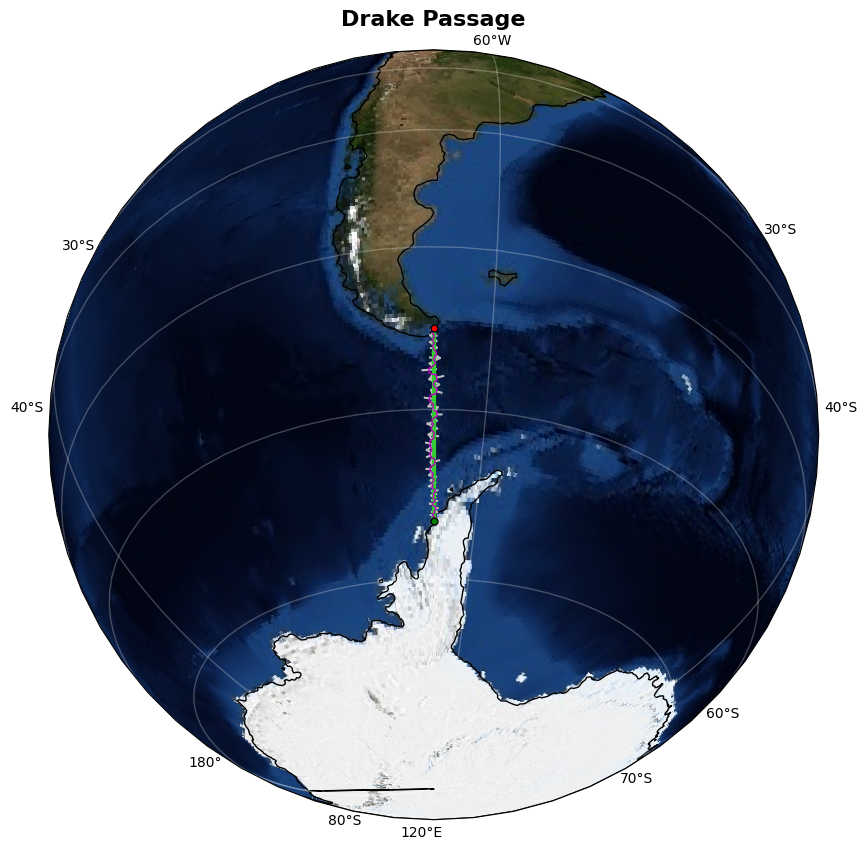

30°W, 80°S-90°N


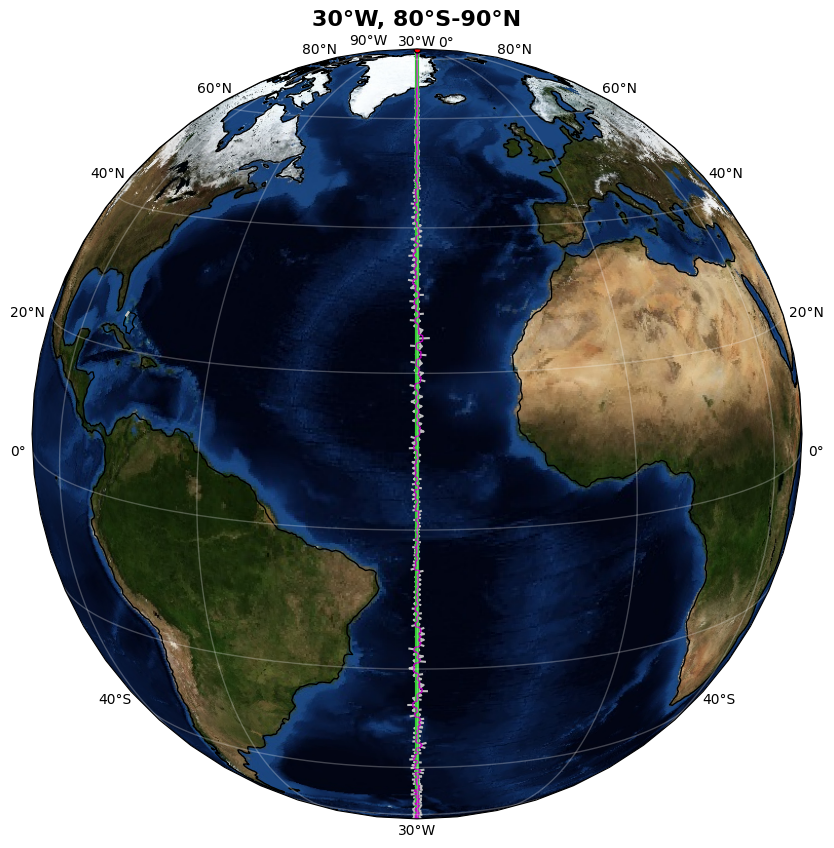

 --> elasped time: 0.14973042408625284 min.


In [6]:
#______________________________________________________________________________________________________    
# load information about edges 
ts = clock.time()
datapath = input_paths[0]
fname    = 'fesom.mesh.diag.nc'
# check for directory with diagnostic file
if   os.path.isfile( os.path.join(datapath, fname) ): 
    dname = datapath
elif os.path.isfile( os.path.join( os.path.join(os.path.dirname(os.path.normpath(datapath)),'1/'), fname) ): 
    dname = os.path.join(os.path.dirname(os.path.normpath(datapath)),'1/')
elif os.path.isfile( os.path.join(mesh.path,fname) ): 
    dname = mesh.path
else:
    raise ValueError('could not find directory with...mesh.diag.nc file')    

#___________________________________________________________________________
# set specfic type when loading --> #convert to specific precision
# drop unnecessary variables:  Based on the documentation (but a bit hidden), 
# the "data_vars=" argument only works with Python 3.9.
from functools import partial
var_keep = ['edges', 'edge_tri', 'edge_cross_dxdy', 'nod_in_elem2D', 'edge_nodes', 'edge_face_links' ]
def _preprocess(x):
    for var in list(x.keys()):
        if var not in var_keep: 
            x = x.drop_vars(var)
            continue
            
        if x[var].dtype=='float64': x[var] = x[var].astype('float32')
        # there were some changings in the fesom.mesh.diag.nc variable naming from fesom 2.5-->2.6
        # for some reason he load now edge_nodes and edge_face_links as float32, while they cant
        # be used as indices by default and need to be converted by hand into int32
        if   var in ['edge_nodes'     ]: x = x.rename({'edge_nodes'     :'edges'})#.astype('int32')                
        elif var in ['edge_face_links']: x = x.rename({'edge_face_links':'edge_tri'})#.astype('int32')                
    return x
partial_func = partial(_preprocess)

#___________________________________________________________________________
# load diag file --> apply drop variables by preprocessor function
# decode_cf=False is need so that the original fillvalue of -999 is used instead of NaN
# or np.iinfo(np.int32).max()
mdiag = xr.open_mfdataset(os.path.join(dname,fname), parallel=False, 
                             chunks=dict({'edg_n':'auto'}), engine='netcdf4', 
                             preprocess=partial_func,  decode_cf=False)
mdiag = mdiag.drop_vars(list(mdiag.coords)).load()

# node indices of edge points [2 x n2ded]
edge       = mdiag['edges'].values-1
# element indices of triangles that are left and right of edg: [2 x n2ded]
edge_tri   = mdiag['edge_tri'].values-1
# dx & dy of edge midpoints towards element centroid of left and right triangle
edge_dxdy  = mdiag['edge_cross_dxdy'].values[:]

# Be sure that the edge_cross_dxdy variable is in the same rotational frame as your velocities. By default
# edge_cross_dxdy is in rotated coordinates. So if you velocities are also in rotated coordinates things are fine.
# If your velocities should be in geo coordinates than edge_cross_dxdy needs to be rotated as well into geo
# coordinates (do_edgevec_r2g=True)
if (do_edgevec_r2g):
    edm_x = mesh.n_x[edge].sum(axis=0)/2.0
    edm_y = mesh.n_y[edge].sum(axis=0)/2.0
    edge_dxdy[0,:], edge_dxdy[1,:] = tpv.vec_r2g(mesh.abg, edm_x, edm_y, edge_dxdy[0,:], edge_dxdy[1,:], gridis='geo', do_info=False )
    edge_dxdy[2,:], edge_dxdy[3,:] = tpv.vec_r2g(mesh.abg, edm_x, edm_y, edge_dxdy[2,:], edge_dxdy[3,:], gridis='geo', do_info=False )
    del(edm_x, edm_y)
    
# [L]eft  triangle: dx, dy
edge_dxdy_l= np.array([ edge_dxdy[0,:], edge_dxdy[1,:]])
# [R]ight triangle: dx, dy
edge_dxdy_r= np.array([ edge_dxdy[2,:], edge_dxdy[3,:]])
edge_dxdy_r[:, edge_tri[1,:]<0]=0. # if boundarie edge --> right triangle doesnot exist
del(edge_dxdy)

# only needed for plotting transects when scalar data are on elements, here temp and salt are on vertices
# nodeinelem = mdiag['nod_in_elem2D'].values[:,:]-1

#______________________________________________________________________________________________________    
# analyse transects computes all neccesary arrays 
transects = tpv.do_analyse_transects(input_transect, mesh, edge, edge_tri, edge_dxdy_l, edge_dxdy_r)
for transect in transects:
    print(transect['Name'])
    fig, ax = tpv.plot_transect_position(mesh, transect, edge=edge)

print(' --> elasped time: {} min.'.format( (clock.time()-ts)/60  ))

In [7]:
#___LOAD CLIMATOLOGY_____________________________________________________________________________________
clim_vname= vname
if vname in ['temp', 'salt', 'pdens'] or 'sigma' in vname: 
    # load climatology data
    ts = clock.time()
    if   vname=='temp' and  which_clim.lower()=='woa18': clim_vname = 't00an1'
    elif vname=='salt' and  which_clim.lower()=='woa18': clim_vname = 's00an1'
    clim          = tpv.load_climatology(mesh, clim_path, clim_vname)
    print(' --> elasped time to load clim: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> clim uses {:3.2f} Gb:'.format(clim.nbytes/(1024**3)))
    print('')

    # compute transect on climatology data
    ts = clock.time()
    clim_csect = tpv.calc_transect_scalar(mesh, clim, transects)
    print(' --> elasped time to comp. clim transect.: {:3.2f} sec.'.format( (clock.time()-ts)  ))   
    for ii, data_ii in enumerate(clim_csect):
        print(' --> clim_transect[{:s}] uses {:3.2f} Mb:'.format(clim_csect[ii][list(clim_csect[ii].keys())[0]].attrs['transect_name'], clim_csect[ii].nbytes/(1024**2)))
    print('')  
    del clim
else: raise ValueError('climatology not supported for choosen vname')   
    
#___LOAD FESOM2 DATA___________________________________________________________________________________
data_list = list()
for datapath, descript in zip(input_paths, input_names):
    print(datapath, descript)
    ts = clock.time()
    data          = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=year, mon=mon, descript=descript,
                                          do_info=False, do_zarithm='None', do_ie2n=False, do_nan=False, do_parallel=do_parallel)
    
    #__________________________________________________________________________________________________    
    # check if data where loaded
    if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    print(' --> elasped time to load data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(data.nbytes/(1024**3)))
    print('')
    
    #__________________________________________________________________________________________________
    # compute section on data
    ts = clock.time()
    csect = tpv.calc_transect_scalar(mesh, data, transects)
    del(data)
    print(' --> elasped time to comp. data transect.: {:3.2f} sec.'.format( (clock.time()-ts)  ))   
    for ii, data_ii in enumerate(csect):
        print(' --> csect[{:s}] uses {:3.2f} Mb:'.format(csect[ii][list(csect[ii].keys())[0]].attrs['transect_name'], csect[ii].nbytes/(1024**2)))
    print('') 

    # compute anomaly with respect to climatology
    csect = tpv.do_transect_anomaly(csect, clim_csect)
    data_list.append(csect)
    del(csect)
del(clim_csect)

['salt']
 --> elasped time to load clim: 0.02 min.
 --> clim uses 0.05 Gb:

 --> elasped time to comp. clim transect.: 0.01 sec.
 --> clim_transect[Drake Passage] uses 0.02 Mb:
 --> clim_transect[30°W, 80°S-90°N] uses 0.25 Mb:

/work/ab0995/a270275/experiments/5Ymulti_diag/outdata/fesom/ Fesom 2.6
 --> elasped time to load data: 0.01 min.
 --> data uses 0.05 Gb:

 --> elasped time to comp. data transect.: 0.01 sec.
 --> csect[Drake Passage] uses 0.02 Mb:
 --> csect[30°W, 80°S-90°N] uses 0.25 Mb:



--> histo: cmin, cmax =  -0.4144019009216683 1.8755382186824736
{'cstr': 'blue2red', 'cnum': 15, 'cref': np.int64(0), 'chist': True, 'ctresh': 0.995, 'cnlab': 8, 'cmin': np.float64(-0.41), 'cmax': np.float64(1.88), 'cmap': <matplotlib.colors.ListedColormap object at 0x7fff2df62730>, 'clevel': array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,
        0.6,  0.7,  0.8,  0.9,  1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,
        1.7,  1.8,  1.9]), 'clab': array([-0.4,  0. ,  0.4,  0.8,  1.2,  1.6])}
 > save figure: /work/ab0995/a270275/runconfig/test/temp_transectclim_drake_passage_y1960-1961.png


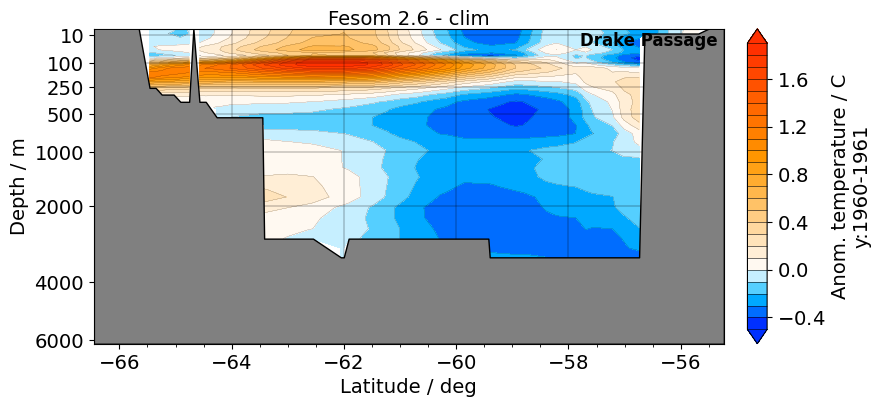

--> histo: cmin, cmax =  -1.7787946635071201 1.7093932340698044
{'cstr': 'blue2red', 'cnum': 15, 'cref': np.int64(0), 'chist': True, 'ctresh': 0.995, 'cnlab': 8, 'cmin': np.float64(-1.78), 'cmax': np.float64(1.71), 'cmap': <matplotlib.colors.ListedColormap object at 0x7fff2dffffa0>, 'clevel': array([-1.8, -1.6, -1.4, -1.2, -1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,
        0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8]), 'clab': array([-1.8, -1.2, -0.6,  0. ,  0.6,  1.2,  1.8])}
 > save figure: /work/ab0995/a270275/runconfig/test/temp_transectclim_30°w,_80°s-90°n_y1960-1961.png


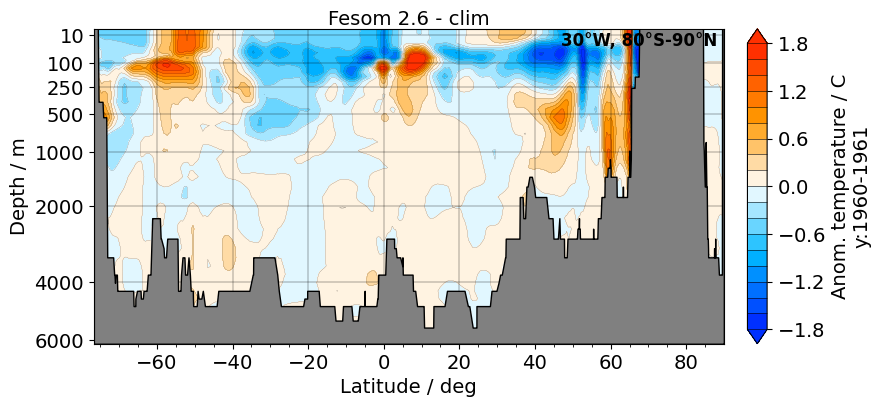

In [8]:
#___PLOT TRANSECT______________________________________________________________________________________
ntrs, ndat = len(transects), len(data_list)
if   ncol != None: 
    ncol0  = np.min([ncol,ndat])    
    nrow0  = np.ceil(ndat/ncol0).astype('int')
elif nrow != None: 
    nrow0  = np.min([nrow,ndat])    
    ncol0  = np.ceil(ndat/nrow0).astype('int')

for trs_idx in range(ntrs):
    svname = list(data_list[0][trs_idx].data_vars)[0]
    slabel = data_list[0][trs_idx][svname].attrs['str_lsave']
    stname = data_list[0][trs_idx][svname].attrs['transect_name'].replace(' ','_').lower()
    #__________________________________________________________________________________________________
    # do save filename path
    spath  = save_path
    sfpath = None
    if spath!=None: 
        sfpath=list()
        for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}_{:s}.{:s}'.format(svname, 'transectclim', stname ,slabel, sfmt)) )
    if save_fname!=None: sfpath = [save_fname] # --> needed for diagrun papermille functionality
    
    #__________________________________________________________________________________________________
    # do colorbar either single cbar or ref_cbar + anom_cbar
    cb_plt, cb_plt_single, cinfo0 = True, True, cinfo.copy() 
    
    #__________________________________________________________________________________________________    
    hfig, hax, hcb = tpv.plot_vslice(mesh, data_list, nrow=nrow0, ncol=ncol0, box_idx=trs_idx, 
                                     cinfo=cinfo0, do_rescale=do_rescale, 
                                     do_plt=do_plt, plt_contb=plt_contb, plt_contf=plt_contf, plt_contr=plt_contr, plt_contl=plt_contl, do_enum=do_enum, 
                                     ax_opt=dict({'fig_sizefac':2.0, 'cb_plt':cb_plt, 'cb_plt_single':cb_plt_single, 'cb_pos':'vertical', 'cb_h':'auto',}), # 'fs_label':14, 'fs_ticks':14, 'ax_dt':1.0}),
                                     cbl_opt=dict(), cb_label=cb_label, cbtl_opt=dict(),
                                     do_save=sfpath, save_dpi=save_dpi )    

In [9]:
if do_papermill and do_parallel and client_runs:
    client.shutdown()
    client_runs = False

2025-01-22 16:58:25,341 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/home/a/a270275/.conda/envs/py39/lib/python3.9/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/a/a270275/.conda/envs/py39/lib/python3.9/site-packages/distributed/worker.py", line 1250, in heartbeat
    response = await retry_operation(
  File "/home/a/a270275/.conda/envs/py39/lib/python3.9/site-packages/distributed/utils_comm.py", line 459, in retry_operation
    return await retry(
  File "/home/a/a270275/.conda/envs/py39/lib/python3.9/site-packages/distributed/utils_comm.py", line 438, in retry
    return await coro()
  File "/home/a/a270275/.conda/envs/py39/lib/python3.9/site-packages/dis